In [1]:
import numpy as np
import pandas as pd
import requests
from io import BytesIO
from sklearn.model_selection import train_test_split, cross_val_score, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import xgboost as xgb
from xgboost import XGBRegressor
import statsmodels.api as sm

In [2]:
# Function to download dataset
def download_dataset(url):
    response = requests.get(url)
    data = pd.read_csv(BytesIO(response.content), compression='gzip')
    return data

# Scaling functions
def x_scale(x, p=7.5):
    return 1/p * np.log(1 + x * (np.exp(p) - 1))

def y_scale(y):
    return np.log(1 + y) if y >= 0 else -np.log(1 - y)


In [3]:
# Download dataset
url = "http://129.10.224.71/~apaul/data/tests/dataset.csv.gz"
dataset = download_dataset(url)


In [4]:
dataset.head() 

,x1,x2,x3,x4,y1,y2
0,0.000001,0.531085,0.855767,0.611623,4.970868,-6.548192
1,0.000002,0.495374,0.961166,0.213009,70.588434,-79.824819
2,0.000002,0.045435,0.109773,0.292582,75.105905,-77.123068
3,0.000002,0.064068,0.774908,0.820672,93.196487,-96.298052
4,0.000003,0.606808,0.861252,0.604051,-27.099713,26.709271


In [5]:
# dataset has 4 input and 2 output variables 

In [6]:
dataset.shape[0]

1000000

In [8]:
print(dataset.describe())

                 x1            x2              x3            x4  \
count  1.000000e+06  1.000000e+06  1000000.000000  1.000000e+06   
mean   1.341361e-01  5.004208e-01        0.500029  4.997152e-01   
std    2.228282e-01  2.894145e-01        0.288862  2.888678e-01   
min    1.123149e-08  2.786075e-07        0.000002  4.108730e-07   
25%    3.136983e-03  2.495269e-01        0.249950  2.499036e-01   
50%    2.324297e-02  5.005487e-01        0.500051  4.995303e-01   
75%    1.547845e-01  7.513006e-01        0.750441  7.496295e-01   
max    9.999968e-01  9.999999e-01        0.999999  9.999988e-01   

                   y1              y2  
count  1000000.000000  1000000.000000  
mean        -0.361455        0.013398  
std        166.307649      102.067963  
min     -28601.393163   -20318.806941  
25%        -32.299643      -20.160210  
50%         -0.058006        0.022538  
75%         32.163591       20.161896  
max      15633.619077    21330.138359  


In [9]:
print(dataset.isnull().sum())

x1    0
x2    0
x3    0
x4    0
y1    0
y2    0
dtype: int64


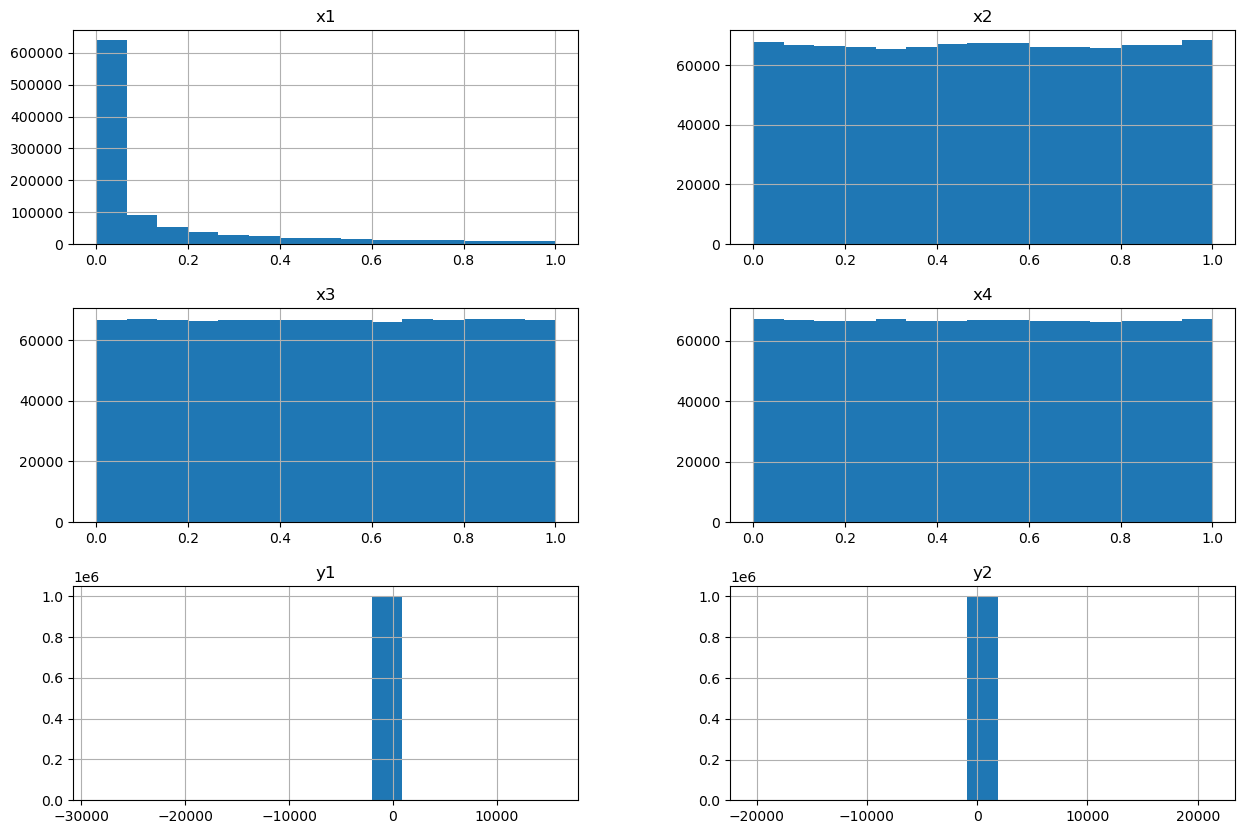

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
# Visualize distributions of numerical features
dataset.hist(bins=15, figsize=(15, 10))
plt.show()

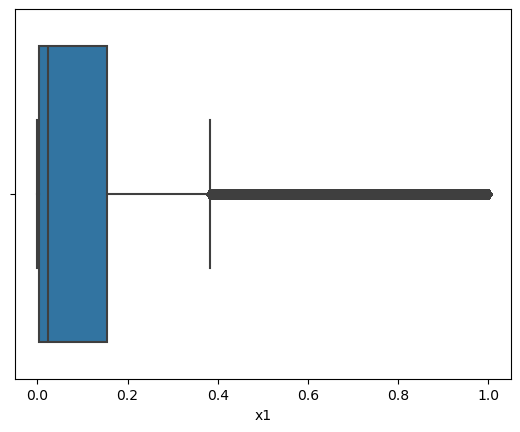

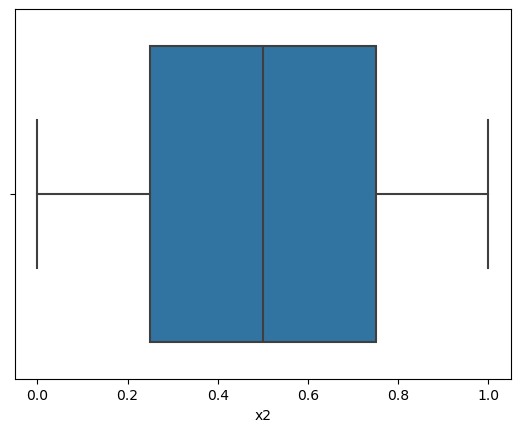

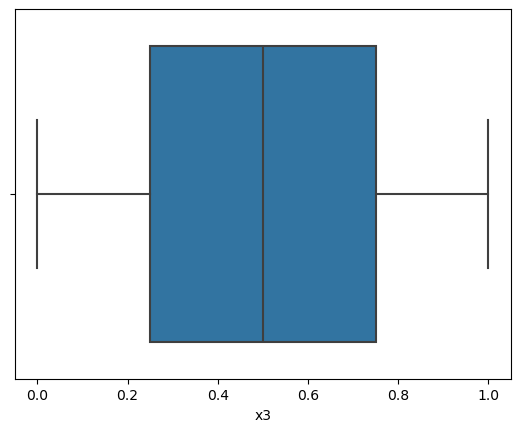

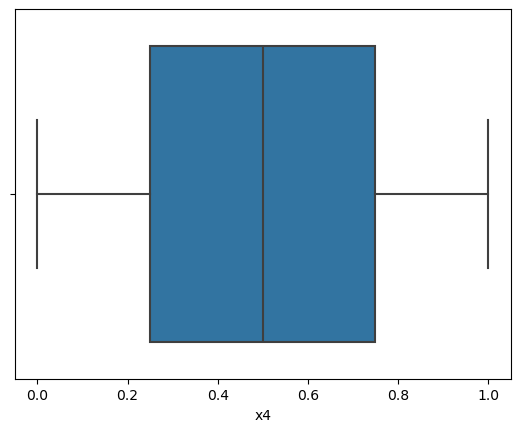

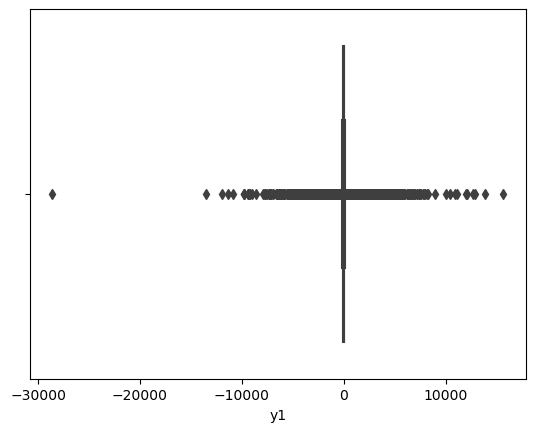

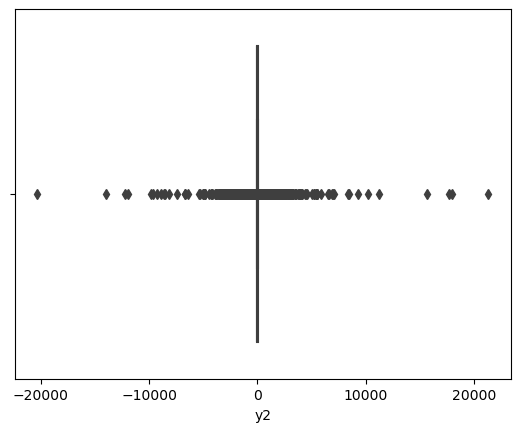

In [11]:
# Box plots to visualize outliers
for column in dataset.select_dtypes(include=['float64', 'int64']).columns:
    plt.figure()
    sns.boxplot(x=dataset[column])

In [12]:
# Pairwise correlation of columns
correlation_matrix = dataset.corr()
print(correlation_matrix)

          x1        x2        x3        x4        y1        y2
x1  1.000000 -0.000128 -0.000357 -0.001126 -0.003125  0.001271
x2 -0.000128  1.000000 -0.001026 -0.000234 -0.502923  0.342698
x3 -0.000357 -0.001026  1.000000 -0.000064  0.043201 -0.127440
x4 -0.001126 -0.000234 -0.000064  1.000000 -0.041055  0.127173
y1 -0.003125 -0.502923  0.043201 -0.041055  1.000000  0.027833
y2  0.001271  0.342698 -0.127440  0.127173  0.027833  1.000000


In [13]:
# Add a constant to the features for the intercept
X = dataset[['x1', 'x2', 'x3', 'x4']]
X_with_const = sm.add_constant(X)

# Fit the linear regression model
y = dataset['y2']
model = sm.OLS(y, X_with_const).fit()

# Print out the summary which includes p-values among other statistics
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                     y2   R-squared:                       0.150
Model:                            OLS   Adj. R-squared:                  0.150
Method:                 Least Squares   F-statistic:                 4.404e+04
Date:                Fri, 29 Mar 2024   Prob (F-statistic):               0.00
Time:                        20:00:41   Log-Likelihood:            -5.9634e+06
No. Observations:             1000000   AIC:                         1.193e+07
Df Residuals:                  999995   BIC:                         1.193e+07
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -60.5511      0.303   -199.961      0.0

In [14]:
# Add a constant to the features for the intercept
X = dataset[['x1', 'x2', 'x3', 'x4']]
X_with_const = sm.add_constant(X)

# Fit the linear regression model
y = dataset['y1']
model = sm.OLS(y, X_with_const).fit()

# Print out the summary which includes p-values among other statistics
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                     y1   R-squared:                       0.256
Model:                            OLS   Adj. R-squared:                  0.256
Method:                 Least Squares   F-statistic:                 8.623e+04
Date:                Fri, 29 Mar 2024   Prob (F-statistic):               0.00
Time:                        20:00:41   Log-Likelihood:            -6.3846e+06
No. Observations:             1000000   AIC:                         1.277e+07
Df Residuals:                  999995   BIC:                         1.277e+07
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        144.1299      0.461    312.368      0.0

In [15]:
# Apply scaling
dataset['x1'] = dataset['x1'].apply(x_scale)
dataset['y1'] = dataset['y1'].apply(y_scale)

X = dataset[['x1', 'x2', 'x3', 'x4']]
y = dataset['y1']

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [17]:
# Train XGBoost model
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)

# Hyper parameters chosen depending on how well they are contributing to the better performance of the model.
params = {
    'max_depth': 9,  # Chosen for model complexity and to avoid overfitting, optimal for dataset structure.
    'eta': 0.1,  # Learning rate set to ensure steady convergence.
    'min_child_weight': 10,  # Helps prevent overfitting by controlling the decision-making process.
    'gamma': 0,  # Minimal loss reduction required for further partition, set to 0 for baseline model complexity.
    'colsample_bytree': 1.0,  # Use all features for each tree to maximize model learning potential.
    'objective': 'reg:squarederror',  # Objective for regression tasks.
    'eval_metric': 'rmse'  # Evaluation metric to focus on minimizing prediction error.
}
num_round = 100 # Number of boosting rounds

[0]	eval-rmse:3.27157	train-rmse:3.27468
[1]	eval-rmse:2.95187	train-rmse:2.95424
[2]	eval-rmse:2.66404	train-rmse:2.66579
[3]	eval-rmse:2.40520	train-rmse:2.40630


/opt/anaconda3/lib/python3.11/site-packages/xgboost/core.py:727: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


[4]	eval-rmse:2.17217	train-rmse:2.17259
[5]	eval-rmse:1.96314	train-rmse:1.96299
[6]	eval-rmse:1.77506	train-rmse:1.77427
[7]	eval-rmse:1.60529	train-rmse:1.60397
[8]	eval-rmse:1.45281	train-rmse:1.45088
[9]	eval-rmse:1.31557	train-rmse:1.31306
[10]	eval-rmse:1.19228	train-rmse:1.18925
[11]	eval-rmse:1.08159	train-rmse:1.07799
[12]	eval-rmse:0.98220	train-rmse:0.97799
[13]	eval-rmse:0.89340	train-rmse:0.88856
[14]	eval-rmse:0.81329	train-rmse:0.80784
[15]	eval-rmse:0.74193	train-rmse:0.73585
[16]	eval-rmse:0.67796	train-rmse:0.67112
[17]	eval-rmse:0.62071	train-rmse:0.61309
[18]	eval-rmse:0.56964	train-rmse:0.56124
[19]	eval-rmse:0.52377	train-rmse:0.51455
[20]	eval-rmse:0.48316	train-rmse:0.47314
[21]	eval-rmse:0.44628	train-rmse:0.43548
[22]	eval-rmse:0.41407	train-rmse:0.40242
[23]	eval-rmse:0.38545	train-rmse:0.37293
[24]	eval-rmse:0.36019	train-rmse:0.34679
[25]	eval-rmse:0.33793	train-rmse:0.32372
[26]	eval-rmse:0.31784	train-rmse:0.30282
[27]	eval-rmse:0.29969	train-rmse:0.2838

In [ ]:
evallist = [(dval, 'eval'), (dtrain, 'train')]
bst = xgb.train(params, dtrain, num_round, evallist, early_stopping_rounds=10)

# Evaluating the model with test data
dtest = xgb.DMatrix(X_test, label=y_test)
y_pred = bst.predict(dtest)

# Calculate RMSE, MAE, and R-squared
test_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
test_mae = mean_absolute_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)

print(f"Test RMSE: {test_rmse}")
print(f"Test MAE: {test_mae}")
print(f"Test R-squared: {test_r2}")